In [1]:
# Librerias basicas 
import numpy as np 
import pandas as pd 
import os
import re
import json

# Visualizacióon
import matplotlib.pyplot as plt
import seaborn as sns 
from plotly import express as px
from scipy import stats

# Funciones auxiliares sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc, accuracy_score, mean_squared_error, mean_absolute_error, r2_score, classification_report # Metricas
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Guardar modelos
import pickle

# Models
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

# WoE
from category_encoders import *

# Preprocesamiento de datos
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


# Plot de matriz de confusion normalizada en actuals
#from utils import plot_confusion_matrix, get_artifact_filename

# Optimizacion de hiperparametros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact
from functools import partial

#Guardado de objetos en archivos joblib
from joblib import load, dump


from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('spanish'))
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings("ignore")

c:\Users\Usuario\.conda\envs\ldi2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
bbdd = "sqlite:///ivan.sqlite3"

In [2]:
df = pd.read_excel('../dataset_2023.xlsx')
df.head(2)

,Tipo comp.,NÂ° cuenta,Desc. Cuenta,NÂ° TesorerÃ­a,Desc. TesorerÃ­a,NÂ° Entidad,Desc. Entidad,Tipo Pres.,Tipo Reg.,Clase Reg.,Cod.,Fte. Fin.,Cuit,Beneficiario,Descripcion,Tipo cta,Cod. Bco.,Class
0,AF,360000003873122,SGP-RENTAS GRALES-PAGADORA ...,1,TESORERIA GENERAL DE LA PROVINCIA,50,SAF OBLIGACIONES A CARGO DEL TESORO,E,ANT,,229,10,30517999551,CAJA POPULAR DE AHORROS DE LA PROVINCIA DE TUC...,AFR-PLAN DE OBRAS- EQUIPAMIENTOS Y SERVICIOS 2022,R,7,ANR
1,AF,71111333,SGP - CTA PAGADORA- CHEQUES DIFERIDOS ...,1,TESORERIA GENERAL DE LA PROVINCIA,50,SAF OBLIGACIONES A CARGO DEL TESORO,E,ANT,,229,10,30517999551,CAJA POPULAR DE AHORROS DE LA PROVINCIA DE TUC...,D-312-ME-22-FONDOS P-EROGACIONES PLAN OBRAS,P,7,PTE


In [11]:
df.isna().sum()

Tipo comp.          0
NÂ° cuenta          0
Desc. Cuenta        0
NÂ° TesorerÃ­a      0
Desc. TesorerÃ­a    0
NÂ° Entidad         0
Desc. Entidad       0
Tipo Pres.          0
Tipo Reg.           0
Clase Reg.          0
Cod.                0
Fte. Fin.           0
Cuit                0
Beneficiario        0
Descripcion         1
Tipo cta            0
Cod. Bco.           0
Class               0
dtype: int64

In [26]:
df.shape

(46367, 20)

##### Distribucion del target

In [3]:
Class = list(df.Class.unique())
clases = {val:Class.index(val) for val in Class}
def get_class(val):
    return clases[val]

df['target'] = df['Class'].apply(get_class)

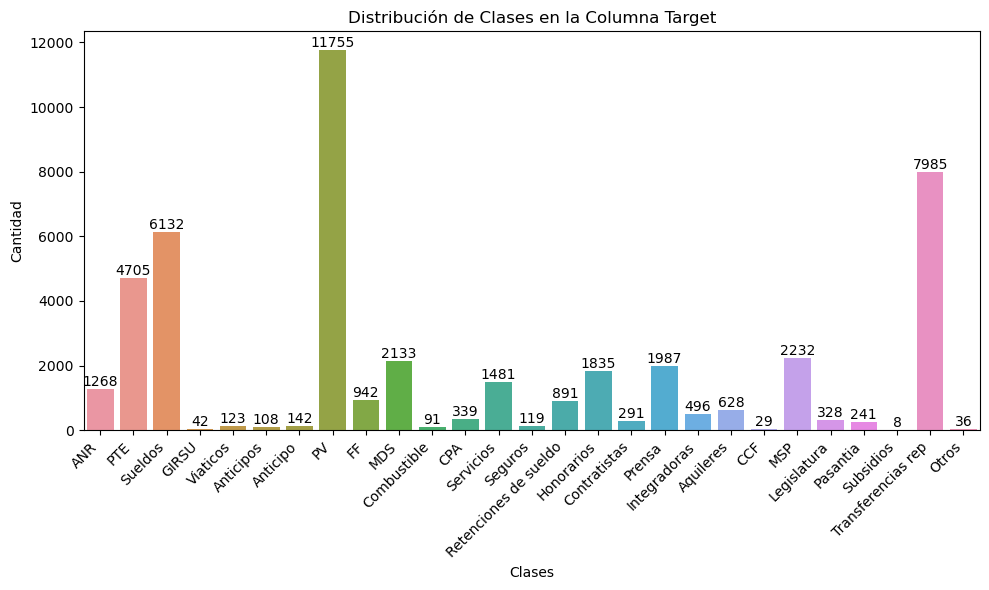

In [18]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Class', data=df)

plt.title('Distribución de Clases en la Columna Target')
plt.xlabel('Clases')
plt.ylabel('Cantidad')

# Añadir etiquetas de cantidad sobre cada barra
for i in ax.containers:
    ax.bar_label(i)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Categoria')

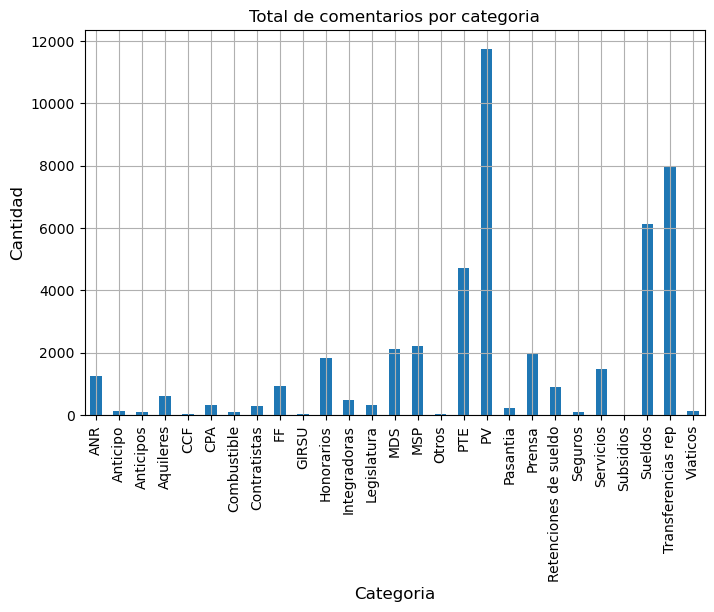

In [7]:
df_group = df.groupby(['Class']).size().reset_index(name='counts')
df_group.plot(x='Class', y='counts', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Total de comentarios por categoria")
plt.ylabel('Cantidad', fontsize=12)
plt.xlabel('Categoria', fontsize=12)

##### Longitud de los comentarios

In [4]:
df['Descripcion'] = df['Descripcion'].fillna('')

In [5]:
def get_longitud_text(text):
  return len(text)

df['Description_length'] = df['Descripcion'].apply(get_longitud_text)
df['Description_length'].describe()

count    46367.000000
mean        50.942265
std          6.939125
min          0.000000
25%         47.000000
50%         52.000000
75%         57.000000
max         60.000000
Name: Description_length, dtype: float64

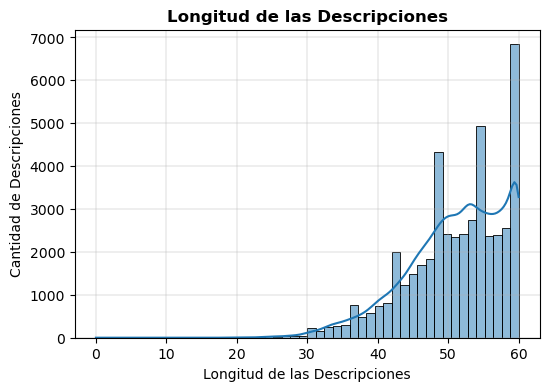

In [15]:
plt.figure(figsize=(6, 4))
sns.histplot(df['Description_length'], kde=True, bins=50)
plt.title('Longitud de las Descripciones', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.ylabel('Cantidad de Descripciones')
plt.xlabel('Longitud de las Descripciones')
plt.grid(linewidth=0.3)
plt.show()

#### Limpieza de datos

In [19]:
df.Descripcion.head(10)

0    AFR-PLAN DE OBRAS- EQUIPAMIENTOS Y SERVICIOS 2022
1          D-312-ME-22-FONDOS P-EROGACIONES PLAN OBRAS
2    AFR-PLAN DE OBRAS-EQUIPAMIENTO Y SERVICIOS 202...
3    DCTO N-119-SH-22-AFR-PGO HAB-ASIG-FLIAR ENE-22...
4    DCTO N-120-SH-22-AFR-PGO HAB-ASIG-FLIAR ENE-22...
5    DCTO N-121-SH-22-AFR-PGO HAB-ASIG-FLIAR ENE-22...
6    DCTO N-122-SH-22-AFR-PGO HAB-ASIG-FLIAR ENE-22...
7    DCTO N-123-SH-22-AFR- PGO HAB-ASIG-FLIA ENE-22...
8    DCTO N-124-SH-22-AFR-PGO HAB-ASIG-FLIAR ENE-22...
9    DCTO N- 126-SH-22-AFR-PGO HAB-ASG-FLIAR ENE-22...
Name: Descripcion, dtype: object

In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
df.Descripcion.sample(10)

24019             RES- 346-DAYD LIB-SAN PABLO CTA- 360000100739337
36889          RES N995 CTA-1123656 CUIDADOR MORENO P-03-23 SENAYF
14964          R-N- 2534-1 - TUCUMAN FM F-N- 277 - C-N- 10073721-8
15547       RES MIN327-7 SES-CONT DIRECTA 154-22-CC360000001567155
18533          ANR-PAGO HABERES-JUNIO-2023-DEL PERSONAL-CB-98288-5
28326          ARLAB TECN INFORMT- PGO AGOSTO CTA- 360000003063699
26738                         RES 634-4 CTA 1233456 TUCMONEY PG 44
42369      RES N3798 CTA-1123656 CUIDADOR LUNA P-08-23 SENAYF PG34
28063    HAB CONT CORBALAN LUIS 08-23 RES 1445 CTA 360009420737684
40209    RES 716 CTA 1123656 SUBS TRANSP ESPEC ALMIRON 07-23 PG 34
Name: Descripcion, dtype: object

In [19]:
df.Descripcion.tail(10)

46357    R-76-DD-23-SUELDO NOV 2023 ABACA SEBA - CTA 36...
46358    R-75-DD-23-LEY 7991 NOV 2023 ABACA SEBA-CTA 36...
46359    RI 2104-23 CTA 360000200973504 MOVILIDAD DGR 1...
46360                  LEY SERIE 12-23 -CT-360000003285363
46361    R2072- C360000200973511- RESTITUCION HAB-JUARE...
46362    LEY RI 2100-23 CTA 360000200973511 LEY 7991 CA...
46363    LEY RI 2099-23 CTA 360000200973511 LEY 7991 DG...
46364    R-3887-DGC-23-LEY 7991 NOV 2023 - CTA 36000020...
46365         RES-359-RO-LEY7991-HABERES DIC-3  CTA 789009
46366          LEY 7991 HAB DIC-23 R173 C- 360000200983222
Name: Descripcion, dtype: object

CHATGPT

El _stemming_ y la _lematización_ son dos técnicas diferentes, pero complementarias:

- Lematización: Reduce una palabra a su forma base o “lemma”, conservando su significado gramatical (ej. "jugando" -> "jugar").
- Stemming: Recorta las palabras a su raíz (ej. "jugando" -> "jug"), sin tener en cuenta el contexto gramatical, lo que a veces produce resultados menos precisos.

En general, no se recomienda combinar ambas técnicas en un mismo flujo porque la lematización ya ofrece una forma normalizada y gramaticalmente correcta de la palabra. Sin embargo, si quisieras aplicar ambas por alguna razón específica, te dejo un ejemplo:

9036     None
14603    None
2349     None
23332    None
29211    None
29762    None
507      None
11679    None
9029     None
17861    None
21744    None
15732    None
34871    None
2532     None
19727    None
5206     None
9627     None
19492    None
23939    None
410      None
Name: texto_limpio, dtype: object

In [70]:
# Eliminar símbolos y dejar solo palabras y números
text = re.sub(r"[^a-zA-Z0-9\s]", "", "RES638CTA360009420386215CONTRATO PROF-SALVATORE-ENZO 04-23") ### duda: pongo espacio o no??
text

'RES638CTA360009420386215CONTRATO PROFSALVATOREENZO 0423'

In [58]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

# Función para eliminar stop words
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

In [8]:
def separar_texto_de_numeros(texto):
    # Expresión regular para insertar un espacio entre letras y números
    texto = re.sub(r'([a-zA-Z]+)(\d+)', r'\1 \2', texto)
    texto = re.sub(r'(\d+)([a-zA-Z]+)', r'\1 \2', texto)
    return texto

In [44]:
################### BORRRARRRRRRRRR ######################
import spacy
import re
from nltk.corpus import stopwords
stop_words = list(stopwords.words('spanish'))  ### dos formas de atacar las stopwords: con esta lista o con la libreria spacy.

# Cargar modelo en español (puedes cambiar el modelo a inglés si es necesario)
nlp = spacy.load("es_core_news_sm")

def preprocessing(text):
    # Eliminar símbolos y dejar solo palabras y números
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    
    # Procesar el texto con spaCy
    doc = nlp(text)
    
    # Lemmatización y eliminación de stopwords, signos y espacios
    clean_text = []
    for token in doc:
        if (
            not token.is_stop  # No incluir stopwords
            and not token.is_punct  # No incluir puntuación
            and not token.like_num  # Opción para excluir números si prefieres solo palabras
        ):
            clean_text.append(token.lemma_.lower())

    return " ".join(clean_text)


# Función para eliminar stop words
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

def limpiar_texto(texto):
    texto = texto.upper()
    texto = re.findall(r"(?!CTA)(?!RES)(?!PAGO)(?!AGO)(?!PAG)[A-Z0-9]{3,}", texto)
    texto = list(dict.fromkeys(texto))
    texto = " ".join(texto).strip()
    return texto

df["texto_limpio"] = df["Descripcion"].apply(preprocessing)
df["texto_limpio"] = df["texto_limpio"].apply(separar_texto_de_numeros)
df["texto_limpio"] = df["texto_limpio"].apply(limpiar_texto)

[('sre', 795), ('edet', 768), ('ret', 659), ('2023', 657), ('liq', 627), ('sac', 412), ('71111222', 280), ('set', 276), ('adic', 259), ('retenciones', 258)]


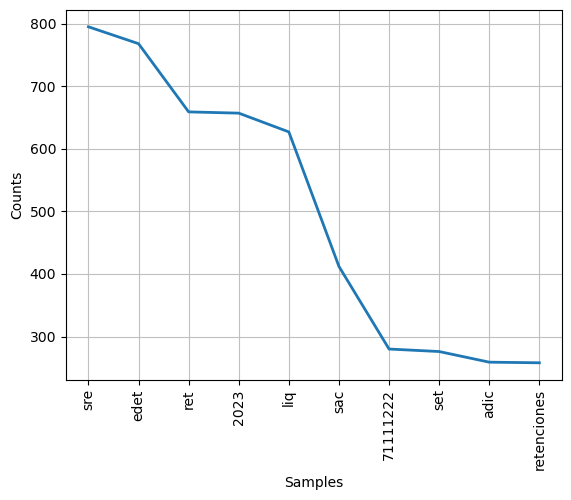

<Axes: xlabel='Samples', ylabel='Counts'>

In [43]:
################### BORRRARRRRRRRRR ######################
import nltk
from nltk.probability import FreqDist
#text = "hola miundo como estas estas"
#nltk.tokenize.word_tokenize(text)
# Concatenar todas las filas de la columna 'texto_limpio' en un solo texto
# combined_text = ' '.join(df['texto_limpio'].astype(str))
combined_text = ' '.join(df[df['target'] == 1]['texto_limpio'].astype(str))



# Tokenizar el texto en palabras
tokens = word_tokenize(combined_text.lower())  # Convertir a minúsculas para contar sin distinción de mayúsculas

# Crear la distribución de frecuencias
fdist = FreqDist(tokens)

# Mostrar las 10 palabras más comunes
print(fdist.most_common(10))

# Graficar la distribución de frecuencias
fdist.plot(10, cumulative=False)

In [37]:
from collections import Counter

# Contar las ocurrencias de cada token
token_counts = Counter(tokens)

# Ordenar de mayor a menor frecuencia
sorted_token_counts = token_counts.most_common()

# Mostrar los resultados
print(sorted_token_counts)


[('1123656', 3924), ('2023', 3592), ('liq', 3137), ('ley', 2074), ('hon', 2036), ('rep', 1502), ('fac', 1500), ('ret', 1375), ('sub', 1370), ('anr', 1357), ('adic', 1296), ('srl', 1277), ('hab', 1236), ('7991', 1216), ('subs', 1186), ('fact', 1153), ('sac', 1087), ('sre', 1036), ('senayf', 1033), ('sli', 1025), ('cuidador', 993), ('edet', 954), ('dic', 943), ('cont', 926), ('damoysp', 892), ('cuid', 877), ('set', 836), ('haberes', 820), ('esc', 768), ('cbu', 753), ('san', 748), ('sueldo', 748), ('serv', 724), ('reint', 710), ('mayo', 699), ('telecom', 673), ('mes', 623), ('escolar', 622), ('abril', 604), ('nov', 598), ('dif', 594), ('2022', 574), ('obra', 562), ('360000100735410', 558), ('julio', 550), ('sem', 521), ('pablo', 520), ('dev', 518), ('rec', 504), ('fdo', 504), ('arg', 501), ('972464', 473), ('marzo', 469), ('sat', 469), ('enero', 459), ('art', 455), ('junio', 449), ('sepyme', 435), ('feb', 435), ('cert', 433), ('alq', 433), ('212', 432), ('sema', 426), ('prov', 425), ('gos

In [9]:
import spacy
nlp = spacy.load("en_core_web_sm")
# python -m spacy download es_core_news_sm


def eliminar_puntuacion(text):
  """
  no stop words + lematizacion
  """
  clean_text = []
  
  for token in nlp(text):
    if (
        not token.is_stop
        and not token.is_punct
        and not token.like_url
        
    ):
        clean_text.append(token.lemma_.upper())  ### APLICACION DE LEMATIZACION!

  return " ".join(clean_text)



def eliminar_puntuacion_2(texto):
  """
  Malisimo.
  """
  # Expresión regular para eliminar signos de puntuación
  texto = re.sub(r'[^\w\s]', '', texto)
  texto = " ".join(texto).strip()
  return texto

In [10]:
print(re.findall(r"(?!CTA)(?!RES)(?!PAGO)(?!AGO)(?!PAG)[A-Z0-9]{3,}", df['Descripcion'][3]))

def limpiar_texto(texto):
    texto = texto.upper()
    texto = re.findall(r"(?!CTA)(?!RES)(?!PAGO)(?!AGO)(?!PAG)[A-Z0-9]{3,}", texto)
    texto = list(dict.fromkeys(texto))
    texto = " ".join(texto).strip()
    return texto

['DCTO', '119', 'AFR', 'PGO', 'HAB', 'ASIG', 'FLIAR', 'ENE', '200982014']


In [11]:
df["texto_limpio"] = df["Descripcion"].apply(remove_stopwords)

In [13]:
df.texto_limpio.sample(1)

32505    RES-189-UEDP-SANTI ARAOZ- M-10-23-CTA36000010074355-2-F2820
Name: texto_limpio, dtype: object

In [12]:
df["texto_limpio"] = df["texto_limpio"].apply(eliminar_puntuacion)

In [108]:
# df["texto_limpio"] = df["texto_limpio"].apply(eliminar_puntuacion_2)

In [13]:
df["texto_limpio"] = df["texto_limpio"].apply(separar_texto_de_numeros)

In [14]:
df["texto_limpio"] = df["texto_limpio"].apply(limpiar_texto)

In [61]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
df.texto_limpio.head(10)

0                    AFR-PLAN OBRAS- EQUIPAMIENTOS SERVICIOS 2022
1                     D-312-ME-22-FONDOS P-EROGACIONES PLAN OBRAS
2            AFR-PLAN OBRAS-EQUIPAMIENTO SERVICIOS 2022-C-RURALES
3    DCTO N-119-SH-22-AFR-PGO HAB-ASIG-FLIAR ENE-22-CTA 200982014
4    DCTO N-120-SH-22-AFR-PGO HAB-ASIG-FLIAR ENE-22-CTA 200981813
5    DCTO N-121-SH-22-AFR-PGO HAB-ASIG-FLIAR ENE-22-CTA 200982250
6    DCTO N-122-SH-22-AFR-PGO HAB-ASIG-FLIAR ENE-22-CTA 200981738
7    DCTO N-123-SH-22-AFR- PGO HAB-ASIG-FLIA ENE-22-CTA 200981653
8    DCTO N-124-SH-22-AFR-PGO HAB-ASIG-FLIAR ENE-22-CTA 200981776
9    DCTO N- 126-SH-22-AFR-PGO HAB-ASG-FLIAR ENE-22-CTA 200981899
Name: texto_limpio, dtype: object

In [62]:
df.texto_limpio.sample(10)

9089         RI415-23 C360000001889819 F912 LIMP CC EXCTROL VEH 2-23
16079              RES638 SCYC-CONC PRECIOS 188-22-CC360000100746179
29569                  RES1421- EDET SA FACT-62507640 P-09-23 SEMGYD
44921                   RES 6494-4 CTA 1123656 CUID BAZAN 11-23 PG34
19926       HAB CONT AGUERO LORENA 06-23 RES 914 CTA 362809420603123
46030             RES 2982 CTA 1123656 CUID CERMIGNANI P 12-23 PG 34
24714                               OCA LOG S-A- CTA 362809420115655
36225                     RES-42-23- 36000020097556-2-LEY MARZO 2023
814      RES 096 SEMA CTA 36000020098363-5 REP FDO FIJO SEMA PROG 11
14308        RUBIO EDUARDO LIQ 10045 CTA 360009419713361 RES 1949-21
Name: texto_limpio, dtype: object

In [102]:
df.texto_limpio.tail(10)

46357    
46358    
46359    
46360    
46361    
46362    
46363    
46364    
46365    
46366    
Name: texto_limpio, dtype: object

In [71]:
limpiar_texto("RES1313 -194-23-DIEZ D-HUMB-FCTS4-794-791-36000000779324")

'ES1313 194 DIEZ HUMB FCTS4 794 791 36000000779324'

In [28]:
df.Descripcion.iloc[6311]

'RES1313 -194-23-DIEZ D-HUMB-FCTS4-794-791-36000000779324'

In [70]:
df.texto_limpio.iloc[6311]

'ES1313 194 DIEZ HUMB FCTS4 794 791 36000000779324'

In [55]:
print("ES1313 194 DIEZ HUMB FCTS4 794 791 36000000779324")

ES1313 194 DIEZ HUMB FCTS4 794 791 36000000779324


In [70]:
limpiar_texto('RES1313 -194-23-DIEZ D-HUMB-FCTS4-794-791-36000000779324')

'ES1313 194 DIEZ HUMB FCTS4 794 791 36000000779324'

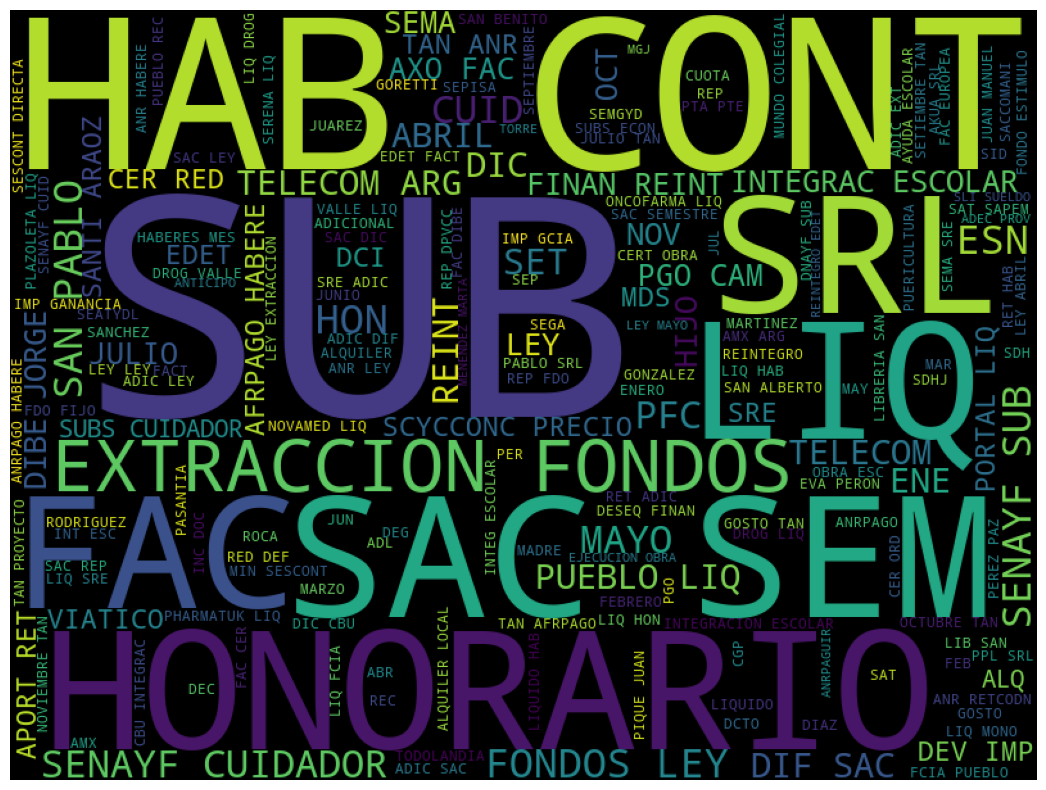

In [31]:
from wordcloud import WordCloud,STOPWORDS

def cloud(data, backgroundcolor = 'black', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
#df['tokens'] = df['texto_limpio'].apply(lambda x : str(x or ""))
#dfwc = df[df['tokens'] != 'nan']
cloud(' '.join(df['texto_limpio']))

In [15]:
Class = list(df.Class.unique())
clases = {val:Class.index(val) for val in Class}
def get_class(val):
    return clases[val]

df['target'] = df['Class'].apply(get_class)

In [33]:
def pesos(texto, dic_words):
    texto = texto.lower()
    palabras = texto.split(' ')
    score = 0
    for palabra in palabras:
        if palabra in dic_words.keys():
            score += dic_words[palabra]
            #print(palabra)
    return score


dictOfWords = {}
for target in df.target.unique():
    df_target = df[df["target"]==target]
    all_descriptions = ' '.join(df_target['texto_limpio'].dropna())  # Concatenar todas las descripciones

    # Tokenización y eliminación de stopwords
    stop_words = set(stopwords.words('spanish')) 
    word_tokens = word_tokenize(all_descriptions.lower())  # Tokenización y convertir a minúsculas
    filtered_words = [word for word in word_tokens if word.isalnum() and word not in stop_words]  # Filtrar stopwords y no palabras alfa
    freq_of_words = pd.Series(filtered_words).value_counts()
    
    
    dic_words = freq_of_words.to_dict()
    dictOfWords[str(target)] = dic_words
    df[f'pesos_{target}'] = df['texto_limpio'].apply(pesos,dic_words=dic_words)

with open('dict_words_ivan.json', 'w') as file:
    json.dump(dictOfWords, file, indent=4)

In [16]:
# onehot encoding
categ = ['Tipo comp.','Tipo Reg.','Clase Reg.','Tipo cta']
for col in categ:
    df = df.join(pd.get_dummies(df[[col]]))
    df.drop(col, axis=1, inplace=True)

In [10]:
features = []
for x in enumerate(df.dtypes):
    if x[1] in ["float64","int64","bool"]:
        features.append(df.columns[x[0]])

remove = [ 'Cuit Pago','dias_pago','target','index', 'Cta. Cte','NÂ° cta. Safyc','CuentaSafyc','NÂ° Comp.', 
          'NÂ° TesorerÃ\xada', 'NÂ° Pago','F. Anulado','F. Revertido', 'Cuit alt.','Id. Pe. Ch.','Monto', 'NÂ° Orig.',]

for col in remove:
    try:
        features.remove(col)
    except: pass
# features.append('texto_limpio')
features

['NÂ° cuenta',
 'NÂ° Entidad',
 'Cod.',
 'Fte. Fin.',
 'Cuit',
 'Cod. Bco.',
 'Description_length',
 'Tipo comp._AF',
 'Tipo comp._FF',
 'Tipo comp._GA',
 'Tipo comp._GC',
 'Tipo comp._GE',
 'Tipo Reg._AMP',
 'Tipo Reg._ANT',
 'Tipo Reg._APE',
 'Tipo Reg._CYO',
 'Tipo Reg._ORD',
 'Tipo Reg._PAG',
 'Tipo Reg._RPO',
 'Clase Reg._   ',
 'Clase Reg._DPU',
 'Clase Reg._OGA',
 'Clase Reg._REM',
 'Tipo cta_P',
 'Tipo cta_R']

In [9]:
SEED = 12345
TEST_SIZE = 0.2

# Supongamos que tu dataframe se llama df
X = df['texto_limpio']  # Columna de texto
y = df['target']  # Variable objetivo (con múltiples clases)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


categories = y.unique()


KeyError: 'texto_limpio'

In [37]:
clases = df.Class.unique()

#### OneVsRestClassifier: solo usando texto_limpio y target

In [11]:
stop_words = list(stopwords.words('spanish')) 
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),
                ])

In [41]:
for category in categories:
    print(f'Procesando Categoria: {category}')
    
    # Ajustar el modelo
    NB_pipeline.fit(X_train, y_train == category)  # Entrenar con una clase binaria
    
    # Realizar predicciones
    predictions = NB_pipeline.predict(X_test)
    
    # Evaluar el modelo
    accuracy = accuracy_score(y_test == category, predictions)
    print(f'Accuracy para la categoría {category}: {accuracy}')

Procesando Categoria: 0
Accuracy para la categoría 0: 0.9870605995255554
Procesando Categoria: 1
Accuracy para la categoría 1: 0.9170800086262669
Procesando Categoria: 2
Accuracy para la categoría 2: 0.9602113435410826
Procesando Categoria: 3
Accuracy para la categoría 3: 0.9987060599525556
Procesando Categoria: 4
Accuracy para la categoría 4: 0.9966573215441018
Procesando Categoria: 5
Accuracy para la categoría 5: 0.9978434332542592
Procesando Categoria: 6
Accuracy para la categoría 6: 0.9969808065559629
Procesando Categoria: 7
Accuracy para la categoría 7: 0.9400474444684063
Procesando Categoria: 8
Accuracy para la categoría 8: 0.9869527711882683
Procesando Categoria: 9
Accuracy para la categoría 9: 0.9635540219969808
Procesando Categoria: 10
Accuracy para la categoría 10: 0.9976277765796852
Procesando Categoria: 11
Accuracy para la categoría 11: 0.9921285313780461
Procesando Categoria: 12
Accuracy para la categoría 12: 0.9776795341815829
Procesando Categoria: 13
Accuracy para la cat

In [42]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
                ])

In [43]:
for category in categories:
    print(f'Procesando Categoria: {category}')
    
    # Ajustar el modelo
    SVC_pipeline.fit(X_train, y_train == category)  # Entrenar con una clase binaria
    
    # Realizar predicciones
    predictions = SVC_pipeline.predict(X_test)
    
    # Evaluar el modelo
    accuracy = accuracy_score(y_test == category, predictions)
    print(f'Accuracy para la categoría {category}: {accuracy}')

Procesando Categoria: 0
Accuracy para la categoría 0: 0.9965494932068147
Procesando Categoria: 1
Accuracy para la categoría 1: 0.9553590683631659
Procesando Categoria: 2
Accuracy para la categoría 2: 0.9894328229458702
Procesando Categoria: 3
Accuracy para la categoría 3: 0.9995686866508519
Procesando Categoria: 4
Accuracy para la categoría 4: 0.9978434332542592
Procesando Categoria: 5
Accuracy para la categoría 5: 0.9985982316152685
Procesando Categoria: 6
Accuracy para la categoría 6: 0.9994608583135648
Procesando Categoria: 7
Accuracy para la categoría 7: 0.9631227086478327
Procesando Categoria: 8
Accuracy para la categoría 8: 0.9984904032779814
Procesando Categoria: 9
Accuracy para la categoría 9: 0.9854431744662497
Procesando Categoria: 10
Accuracy para la categoría 10: 0.9995686866508519
Procesando Categoria: 11
Accuracy para la categoría 11: 0.9966573215441018
Procesando Categoria: 12
Accuracy para la categoría 12: 0.994608583135648
Procesando Categoria: 13
Accuracy para la cate

#### OneVsRestClassifier: dataset completo

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
from sklearn.preprocessing import LabelBinarizer

# Supongamos que tu dataframe se llama df
df = pd.read_csv('tu_dataset.csv')  # Cargar el dataset

# Definir columnas
text_column = 'texto_limpio'
target_column = 'target'

# Definir las columnas de características
numeric_features = ['numeric_col1', 'numeric_col2']  # Reemplaza con tus columnas numéricas
categorical_features = ['categorical_col1', 'categorical_col2']  # Reemplaza con tus columnas categóricas

# Imputación de valores faltantes para las columnas numéricas
numeric_imputer = SimpleImputer(strategy='median')
X_numeric = df[numeric_features]
X_numeric_imputed = numeric_imputer.fit_transform(X_numeric)

# Escalado de características numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric_imputed)

# Imputación y codificación de variables categóricas
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_categorical = df[categorical_features]
X_categorical_imputed = categorical_imputer.fit_transform(X_categorical)

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_categorical_encoded = encoder.fit_transform(X_categorical_imputed)

# Procesamiento de texto
text_processor = TfidfVectorizer(stop_words='spanish')
X_text = df[text_column]
X_text_transformed = text_processor.fit_transform(X_text)

# Combina todas las características procesadas
X_combined = hstack([X_numeric_scaled, X_categorical_encoded, X_text_transformed])

# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, df[target_column], test_size=0.2, random_state=42)

# Crear y ajustar el modelo
model = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))
model.fit(X_train, y_train)

# Realizar predicciones
predictions = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')


FileNotFoundError: [Errno 2] No such file or directory: 'tu_dataset.csv'

['NÂ° cuenta',
 'NÂ° Entidad',
 'Cod.',
 'Fte. Fin.',
 'Cuit',
 'Cod. Bco.',
 'Description_length',
 'pesos_0',
 'pesos_1',
 'pesos_2',
 'pesos_3',
 'pesos_4',
 'pesos_5',
 'pesos_6',
 'pesos_7',
 'pesos_8',
 'pesos_9',
 'pesos_10',
 'pesos_11',
 'pesos_12',
 'pesos_13',
 'pesos_14',
 'pesos_15',
 'pesos_16',
 'pesos_17',
 'pesos_18',
 'pesos_19',
 'pesos_20',
 'pesos_21',
 'pesos_22',
 'pesos_23',
 'pesos_24',
 'pesos_25',
 'pesos_26',
 'Tipo comp._AF',
 'Tipo comp._FF',
 'Tipo comp._GA',
 'Tipo comp._GC',
 'Tipo comp._GE',
 'Tipo Reg._AMP',
 'Tipo Reg._ANT',
 'Tipo Reg._APE',
 'Tipo Reg._CYO',
 'Tipo Reg._ORD',
 'Tipo Reg._PAG',
 'Tipo Reg._RPO',
 'Clase Reg._   ',
 'Clase Reg._DPU',
 'Clase Reg._OGA',
 'Clase Reg._REM',
 'Tipo cta_P',
 'Tipo cta_R']

In [233]:
X_combined

<46367x22537 sparse matrix of type '<class 'numpy.float64'>'
	with 2652053 stored elements in COOrdinate format>

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
from sklearn.preprocessing import LabelBinarizer



# Definir columnas
text_column = 'texto_limpio'
target_column = 'target'

# Definir las columnas de características
numeric_features = features  # Reemplaza con tus columnas numéricas


# Imputación de valores faltantes para las columnas numéricas
numeric_imputer = SimpleImputer(strategy='median')
X_numeric = df[numeric_features]
X_numeric_imputed = numeric_imputer.fit_transform(X_numeric)

# Escalado de características numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric_imputed)



# Procesamiento de texto
stop_words = list(stopwords.words('spanish'))
text_processor = TfidfVectorizer(stop_words=stop_words)
X_text = df[text_column]
X_text_transformed = text_processor.fit_transform(X_text)

# Combina todas las características procesadas
X_combined = hstack([X_numeric_scaled, X_text_transformed])

# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, df[target_column], test_size=0.2, random_state=42)

# Crear y ajustar el modelo
model = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
#model = OneVsRestClassifier(RandomForestClassifier(max_depth=15))
model.fit(X_train, y_train)

# Realizar predicciones
predictions = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')


Accuracy: 0.9370282510243692


In [83]:
import nltk
# nltk.download('averaged_perceptron_tagger')
#  nltk.download('wordnet')
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocessing_todo(text):
    # Paso 1: Eliminar puntuación y espacios extra
    text2 = " ".join("".join([" " if ch in string.punctuation else ch for ch in text]).split())
    
    # Paso 2: Tokenización
    tokens = [word for sent in nltk.sent_tokenize(text2) for word in nltk.word_tokenize(sent)]
    
    # Paso 3: Conversión a minúsculas
    tokens = [word.lower() for word in tokens]
    
    # Paso 4: Eliminación de stopwords
    stopwds = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwds]
    
    # Paso 5: Filtrado de palabras con longitud menor a 3
    tokens = [word for word in tokens if len(word) >= 3]
    
    # Paso 6: Stemming
    stemmer = PorterStemmer()
    try:
        tokens = [stemmer.stem(word) for word in tokens]
    except:
        tokens = tokens
        
    # Paso 7: Etiquetado gramatical (POS tagging)
    tagged_corpus = pos_tag(tokens)
    
    # Paso 8: Lematización considerando etiquetas gramaticales
    Noun_tags = ['NN', 'NNP', 'NNPS', 'NNS']
    Verb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    lemmatizer = WordNetLemmatizer()

    def prat_lemmatize(token, tag):
        if tag in Noun_tags:
            return lemmatizer.lemmatize(token, 'n')
        elif tag in Verb_tags:
            return lemmatizer.lemmatize(token, 'v')
        else:
            return lemmatizer.lemmatize(token, 'n')
    
    # Aplicación de la lematización condicional
    pre_proc_text = " ".join([prat_lemmatize(token, tag) for token, tag in tagged_corpus])
    
    return pre_proc_text


In [84]:
df["texto_limpio"] = df["Descripcion"].apply(preprocessing_todo)
df["texto_limpio"] = df["texto_limpio"].apply(limpiar_texto)

#### Red Neuronal

In [85]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split



# Parámetros
nb_classes = df['target'].nunique()  # Número de clases en la columna target
max_words = 10000  # Número máximo de palabras a considerar
batch_size = 64
nb_epochs = 20

# Tokenizar el texto (convierte 'texto_limpio' de objeto a una matriz numérica)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['texto_limpio'].astype(str))  # Asegúrate de que sea tratado como cadena de texto
X = tokenizer.texts_to_matrix(df['texto_limpio'].astype(str), mode='tfidf')  # Convierte el texto a TF-IDF

# Convertir la columna 'target' a one-hot encoding
y = to_categorical(df['target'], nb_classes)

# Dividir el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

# Crear el modelo
model = Sequential()
model.add(Dense(1000, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epochs, validation_data=(X_test, y_test), verbose=1)

# Hacer predicciones
y_train_predclass = model.predict(X_train, batch_size=batch_size)
y_test_predclass = model.predict(X_test, batch_size=batch_size)

# Convertir las etiquetas y las predicciones a formato ordinal
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
y_train_pred_labels = np.argmax(y_train_predclass, axis=1)
y_test_pred_labels = np.argmax(y_test_predclass, axis=1)

# Calcular la precisión y generar el informe de clasificación
print("Train accuracy: {}".format(round(accuracy_score(y_train_labels, y_train_pred_labels), 3)))
print("Test accuracy: {}".format(round(accuracy_score(y_test_labels, y_test_pred_labels), 3)))
print("\nTest Classification Report\n")
print(classification_report(y_test_labels, y_test_pred_labels))

Epoch 1/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 79s 124ms/step - accuracy: 0.5662 - loss: 1.5459 - val_accuracy: 0.9254 - val_loss: 0.2837
Epoch 2/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 78s 134ms/step - accuracy: 0.9158 - loss: 0.2907 - val_accuracy: 0.9319 - val_loss: 0.2622
Epoch 3/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 82s 141ms/step - accuracy: 0.9491 - loss: 0.1722 - val_accuracy: 0.9353 - val_loss: 0.2729
Epoch 4/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 79s 135ms/step - accuracy: 0.9636 - loss: 0.1246 - val_accuracy: 0.9338 - val_loss: 0.2964
Epoch 5/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 98s 169ms/step - accuracy: 0.9713 - loss: 0.0961 - val_accuracy: 0.9350 - val_loss: 0.3414
Epoch 6/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 131s 149ms/step - accuracy: 0.9757 - loss: 0.0813 - val_accuracy: 0.9347 - val_loss: 0.3593
Epoch 7/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 75s 129ms/step - accuracy: 0.9793 - loss: 0.0722 - val_accuracy: 0.9325 - val_loss: 0.3958
Epoch 8/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 74s 127ms/step - accuracy: 0.9818 - loss: 

Con preprocesamiento ivan fran: 
- Train accuracy: 0.996
- Test accuracy: 0.94

Con preprocesamiento ivan:
- Train accuracy: 0.996
- Test accuracy: 0.935

In [17]:
features = []
for x in enumerate(df.dtypes):
    if x[1] in ["float64","int64","bool"]:
        features.append(df.columns[x[0]])

remove = [ 'Cuit Pago','dias_pago','target','index', 'Cta. Cte','NÂ° cta. Safyc','CuentaSafyc','NÂ° Comp.', 
          'NÂ° TesorerÃ\xada', 'NÂ° Pago','F. Anulado','F. Revertido', 'Cuit alt.','Id. Pe. Ch.','Monto', 'NÂ° Orig.',]

for col in remove:
    try:
        features.remove(col)
    except: pass
# features.append('texto_limpio')
features

['NÂ° cuenta',
 'NÂ° Entidad',
 'Cod.',
 'Fte. Fin.',
 'Cuit',
 'Cod. Bco.',
 'Description_length',
 'Tipo comp._AF',
 'Tipo comp._FF',
 'Tipo comp._GA',
 'Tipo comp._GC',
 'Tipo comp._GE',
 'Tipo Reg._AMP',
 'Tipo Reg._ANT',
 'Tipo Reg._APE',
 'Tipo Reg._CYO',
 'Tipo Reg._ORD',
 'Tipo Reg._PAG',
 'Tipo Reg._RPO',
 'Clase Reg._   ',
 'Clase Reg._DPU',
 'Clase Reg._OGA',
 'Clase Reg._REM',
 'Tipo cta_P',
 'Tipo cta_R']

In [18]:
X.shape, df.shape

NameError: name 'X' is not defined

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import to_categorical

# Parámetros
nb_classes = df['target'].nunique()  # Número de clases en la columna target
max_words = 10000  # Número máximo de palabras a considerar
batch_size = 64
nb_epochs = 20

# Separar las columnas relevantes
X_text = df['texto_limpio'].values  # Columna de texto
X_numeric = df[['NÂ° cuenta', 'NÂ° Entidad', 'Cod.', 'Fte. Fin.', 'Cuit', 'Cod. Bco.', 
                'Description_length', 'Tipo comp._AF', 'Tipo comp._FF', 'Tipo comp._GA', 
                'Tipo comp._GC', 'Tipo comp._GE', 'Tipo Reg._AMP', 'Tipo Reg._ANT', 
                'Tipo Reg._APE', 'Tipo Reg._CYO', 'Tipo Reg._ORD', 'Tipo Reg._PAG', 
                'Tipo Reg._RPO', 'Clase Reg._   ', 'Clase Reg._DPU', 'Clase Reg._OGA', 
                'Clase Reg._REM', 'Tipo cta_P', 'Tipo cta_R']].values  # Features numéricos y booleanos
y = df['target'].values  # Etiqueta (objetivo a predecir)

# Preprocesamiento de datos numéricos y booleanos
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Preprocesamiento de texto usando TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_text_tfidf = vectorizer.fit_transform(X_text).toarray()

# Combinar datos numéricos y texto
X_combined = np.hstack((X_numeric_scaled, X_text_tfidf))

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Convertir las etiquetas a formato one-hot si es multiclase
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Definir la red neuronal
model = Sequential()
model.add(Dense(1000, input_shape=(X_combined.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1]))  # Número de clases en la salida
model.add(Activation('softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
#model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test), verbose=1)
model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epochs, validation_data=(X_test, y_test), verbose=1)



# Hacer predicciones
y_train_predclass = model.predict(X_train, batch_size=batch_size)
y_test_predclass = model.predict(X_test, batch_size=batch_size)

# Convertir las etiquetas y las predicciones a formato ordinal
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
y_train_pred_labels = np.argmax(y_train_predclass, axis=1)
y_test_pred_labels = np.argmax(y_test_predclass, axis=1)

# Calcular la precisión y generar el informe de clasificación
print("Train accuracy: {}".format(round(accuracy_score(y_train_labels, y_train_pred_labels), 3)))
print("Test accuracy: {}".format(round(accuracy_score(y_test_labels, y_test_pred_labels), 3)))
print("\nTest Classification Report\n")
print(classification_report(y_test_labels, y_test_pred_labels))


Epoch 1/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 78s 122ms/step - accuracy: 0.6410 - loss: 1.2856 - val_accuracy: 0.9647 - val_loss: 0.1328
Epoch 2/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 95s 163ms/step - accuracy: 0.9509 - loss: 0.1758 - val_accuracy: 0.9754 - val_loss: 0.0873
Epoch 3/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 88s 151ms/step - accuracy: 0.9737 - loss: 0.0941 - val_accuracy: 0.9777 - val_loss: 0.0807
Epoch 4/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 99s 170ms/step - accuracy: 0.9782 - loss: 0.0720 - val_accuracy: 0.9824 - val_loss: 0.0669
Epoch 5/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 85s 146ms/step - accuracy: 0.9817 - loss: 0.0564 - val_accuracy: 0.9824 - val_loss: 0.0711
Epoch 6/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 90s 155ms/step - accuracy: 0.9827 - loss: 0.0518 - val_accuracy: 0.9841 - val_loss: 0.0635
Epoch 7/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 78s 135ms/step - accuracy: 0.9867 - loss: 0.0408 - val_accuracy: 0.9815 - val_loss: 0.0784
Epoch 8/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 73s 118ms/step - accuracy: 0.9874 - loss: 0

In [25]:
y_train_predclass, y_train_labels, y_train_pred_labels, y_test_pred_labels

(array([[9.4843593e-25, 1.5454563e-28, 3.6553746e-25, ..., 1.7542555e-26,
         7.5962649e-30, 2.4796787e-26],
        [3.0057299e-24, 2.5058809e-30, 7.2111601e-34, ..., 4.5226767e-26,
         4.4294635e-36, 5.0076316e-28],
        [4.2090875e-12, 1.2603827e-37, 1.0000000e+00, ..., 4.6152927e-26,
         1.0230006e-14, 1.0938654e-23],
        ...,
        [1.1460775e-30, 0.0000000e+00, 6.9675196e-19, ..., 5.8577502e-29,
         1.0000000e+00, 7.9498875e-16],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [1.6663578e-09, 4.5177689e-23, 1.0742984e-13, ..., 2.2138228e-13,
         7.8273408e-19, 9.3887429e-19]], dtype=float32),
 array([17,  7,  2, ..., 25,  8,  9], dtype=int64),
 array([17,  7,  2, ..., 25,  8,  9], dtype=int64),
 array([ 2,  7,  7, ...,  9,  7, 25], dtype=int64))